## Tarea 8.3

Considere una curva gaussiana con media $0$ y varianza $1$. Aproxime esta curva con una spline cúbica usando 5 puntos entre $x = 0$ y $x = 2$. Use esta spline para calcular la integral de la función. Compare el resultado con su valor exacto (ver la función de error de tareas anteriores).

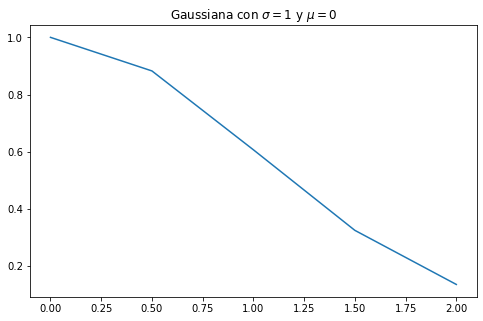

In [2]:
#Importamos los paquetes necesarios
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.integrate import quad
#----------------------------------

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning);

def gaussian(x,sigma=1,mu=0): #Definimos una función que genera una gaussiana
    return np.exp(-(x - mu)**2 / (2*sigma**2)) ### FALTO NORMALIZAR!!!!

x = np.linspace(0,2,5); 
g = gaussian(x); #Generamos una gaussiana con mu=0, sigma=1 entre -5 y +5.

puntos = np.array([(x[i],g[i]) for i in range(len(g))]) #Generamos una matriz con tuplas de la forma (x,f(x))

plt.figure(figsize=(8,5))
plt.plot(x,g);
plt.title('Gaussiana con $\sigma=1$ y $\mu=0$');

In [3]:
#Importamos la función para obtener los coeficiente del ajuste con spline
def spline_coefs(puntos):
    
    n = len(puntos) - 1
    
    h = np.zeros(n)
    for i in range(n):
        h[i] = puntos[i + 1][0] - puntos[i][0]
    
    a = puntos[:,1]
    alpha = np.zeros(n - 1)
    for i in range(1, n):
        alpha[i-1] = (3/h[i])*(a[i+1] - a[i]) - (3/h[i-1])*(a[i] - a[i-1])
        
        
    # Se resuelve un sistema de ecuaciones:
    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)
    for i in range(1, n):
        l[i] = 2*(puntos[i+1][0] - puntos[i-1][0]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i-1] - h[i-1]*z[i-1])/l[i]
    b = np.zeros(n)
    c = np.zeros(n+1)
    d = np.zeros(n)
    for j in range(n-1,-1,-1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j])/h[j] - h[j]*(c[j+1] + 2*c[j])/3
        d[j] = (c[j+1] - c[j])/(3*h[j])
        
    return a, b, c, d

#Función para evaluar los coeficientes
def spline_eval(x, coefs, puntos):

    if x >= puntos[-1,0]:
        return puntos[-1,1]
    elif x <= puntos[0,0]:
        return puntos[0,1]
    
    i = find_ind(x, puntos)
    a, b, c, d = coefs
    return (a[i] + b[i]*(x - puntos[i][0]) + \
            c[i]*(x - puntos[i][0])**2 + d[i]*(x - puntos[i][0])**3)

def find_ind(x, puntos):
    for i in range(len(puntos)):
        if x < puntos[i,0] and i != 0:
            return i-1

Como estamos evaluando un polinomio del tipo $a + bx + cx^2 + dx^3$, su integral es $ax + \frac{b}{2}x^2 + \frac{c}{3}x^3 + \frac{d}{4}x^4$. La spline cubica tiene la forma:

$$
    a + b(x - x_0) + c(x - x_0)^2 + d(x - x_0)^3
$$
Entonces el integral es 
$$
    ax + \frac{a}{2}(x - x_0)^2 + \frac{c}{3}(x - x_0)^3 + \frac{d}{4}(x - x_0)^4    
$$

<span style="color:red;">Cuidado. Esta expresión para la integral no es correcta.</span>

In [4]:
def spline_eval_integral(x, coefs, puntos):

    if x >= puntos[-1,0]:
        return puntos[-1,1]
    elif x <= puntos[0,0]:
        return puntos[0,1]
    
    i = find_ind(x, puntos)
    a, b, c, d = coefs
    return (a[i]*(x) + (b[i]/2)*(x - puntos[i][0])**2 + \
            (c[i]/3)*(x - puntos[i][0])**3 + (d[i]/4)*(x - puntos[i][0])**4)

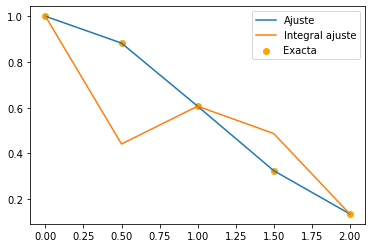

In [5]:
coefs = spline_coefs(puntos)
spline = [spline_eval(xi, coefs, puntos) for xi in x]
spline_integral = [spline_eval_integral(xi,coefs,puntos) for xi in x]
plt.figure(figsize=(6,4))
plt.plot(x,spline,label='Ajuste'); #Ajuste
plt.plot(x,spline_integral,label='Integral ajuste'); #Integral del ajuste
plt.scatter(x,g,c='orange',label='Exacta'); #Exacta
plt.legend();

La formula para un integral definido entre $[a,b]$ es $\int^{b}_{a} = F(b) - F(a)$, debemos restar los puntos $F(x_{n-1}) - F(x_n)$ y sumar los resultados. Esto es debido a al definición de la spline cubica, la cual tiene un polinomio de tercer orden con su propio integral para cada par de puntos. No combiene simplemente resta $F_{x_{n}} - F_{0}$ ya que estos puntos viene de los datos originales y no nos entregarian información nueva. 

Esto es valido gracias a que los integrales podemos separarlos:

$$
\int_{a}^{b}f(x) = \int_{a}^{\xi}f(x) + \int_{\xi}^{b}f(x)
$$

In [6]:
a=[]
for n in range(1,len(spline_integral)):
    a.append(spline_integral[n]-spline_integral[n-1])
sum(a)

-0.8646647167633873

Ahora calculamos el integral de la función pero con ```quad``` de ```scipy.integrate```

In [7]:
integral_scipy = quad(gaussian,0,2,args=(1,0))
integral_scipy

(1.1962880133226081, 1.3281464964738456e-14)

Podemos ver que nuestro intento de calcular el integral con la spline cubica no es muy util. Podemos ver el valor exacto utilizando el paquete ```sympy```

El valor exacto del integral es 0.49766113250947636


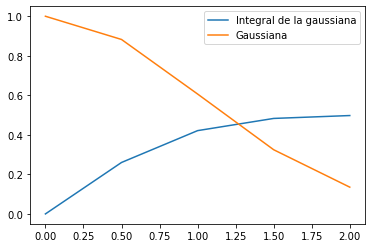

In [24]:
import sympy as sy
x_sy = sy.symbols('x');
exp = sy.exp(-x_sy**2) #Gaussiana son sigma=1 y mu=0 # FALTO NORMALIZAR
exp = sy.exp(-x_sy**2)/sy.sqrt(sy.pi)
gaussian_int = sy.lambdify(x_sy,sy.integrate(exp,x_sy))
plt.plot(x,gaussian_int(x) - gaussian_int(0),label='Integral de la gaussiana');
plt.plot(x,gaussian(x),label='Gaussiana');
plt.legend()
print(f'El valor exacto del integral es {gaussian_int(2) - gaussian_int(0)}')

* Comentario: Profesor no supe una forma más exacta de calcular el integral con la spline :(

# Calificación: 5.5

Hubo un error en las expresiones usadas para la integral.

Como faltó normalizar, incluso métodos estandar dan resultados diferentes. Si se normaliza correctamente, da lo que debería dar:

In [30]:
def gaussian(x,sigma=1,mu=0): #Definimos una función que genera una gaussiana
    return np.exp(-(x - mu)**2 / (2*sigma**2))/np.sqrt(2*np.pi)
integral_scipy = quad(gaussian,0,2,args=(1,0))
integral_scipy

(0.47724986805182085, 5.298537920104494e-15)

In [28]:
exp = sy.exp(-x_sy**2/2)/sy.sqrt(2*sy.pi)
sy.N(sy.integrate(exp,(x_sy,0,2)))

0.477249868051821